In [11]:
# ---- Import libraries ----
import matplotlib.pyplot as plt
import pandas as pd
from gurobipy import *
import numpy as np
import csv


# ---- Parameters ----

"""Importing the dataset and extracting the appropriate data"""

filename = "data_large_3dep.txt"
num_depo = 3
num_vehicle = 6

with open(filename) as f:
    data = csv.reader(f, delimiter="\t")
    dataset = list(data)

for i in range(0, len(dataset)):
    for j in range(0,7):
        a = int(dataset[i][j])
        dataset[i][j] = a
        
dataset = np.array(dataset)
depot = dataset[:num_depo]
customer = dataset[num_depo:]
node_id = dataset[:, 0]  # Stores the id's of the nodes
x_coord = dataset[:, 1]  # Stores the x coordinates of all the nodes
y_coord = dataset[:, 2]  # Stores the y coordinates of all the nodes
a = dataset[:, 3]  # Stores the demand for each node
RT = dataset[:, 4]  # Stores the ready time for each node (earliest time for delivery)
DT = dataset[:, 5]  # Stores the due time for each node (latest time for delivery)
ST = dataset[:, 6]  # Stores the service time for each node (time needed for a delivery at each location )



"""Parameters"""


# Capacities for each vehicle, with the commented out sections being for each case

b = 300*np.ones(num_vehicle, dtype = 'int')  # Case 1
Dc = np.array([5, 0, 0])


# Total number of vehicles
K = len(b)

"""Calculating the Euclidean distance between all nodes """

D = np.zeros((len(a), len(a)))


for i in range(len(node_id)):
    for j in range(len(node_id)):
        D[i , j] = round(np.linalg.norm((x_coord[i] - x_coord[j], y_coord[i] - y_coord[j])), 2)
        


In [ ]:
# ---- Initialising Model ----

model = Model("Part c/d")


# ---- Sets and Indices ----

I = range(len(node_id))  # locations
J = range(len(node_id))  # locations
V = range(K)  # vehicles

# ---- Decision Variables ----

"""Initialising the dimensions for all the decision variables"""
x = model.addVars(I, J, V, vtype = GRB.BINARY, name = "If_Route_Travelled")
z = model.addVars(I, V, vtype = GRB.BINARY, name = "If_Node_Satisfied")
t = model.addVars(I, V, vtype = GRB.CONTINUOUS, name = "Service_Start_Time")
    
    
# # ---- Integerate the variables into the model ----
model.update()


# # ---- Objective Function ----
obj = quicksum(x[i, j, v]*D[i, j] for i in I for j in J for v in V) + quicksum( z[0 , v]*5 for v in V)
model.setObjective(obj, GRB.MINIMIZE)  # Only a function of distance as that is the parameter to minimize

model.update()

# # ---- Constraints ----

M = 4000

# # Ensures that every node is visited by only one vehicle
single_visit = model.addConstrs((quicksum(z[i, v] for v in V) == 1 for i in range(3, len(a))), 
                                "Single_Visit_Satisfaction")

unique_vehicle_depot = model.addConstrs((quicksum(z[i, v] for i in range(3)) <= 1 for v in V), 
                                     "Unique_leaving_Depot")

# total_vehicles = model.addConstr(quicksum(z[i, v] for i in range(3) for v in V) <= K, "Total_Vehicles")

# # Ensures that the sum of demand of a tour of each vehicle needs to be less than overall capacity of the vehicle
vehicle_cap = model.addConstrs((quicksum(a[i]*z[i, v] for i in I) <= b[v] for v in V), "Vehicle_Capacity")

# # Ensures that the number of vehicles leaving a node equals number of vehicles satisfying its demands
vehicle_departure = model.addConstrs((quicksum(x[i, j, v] for j in J) == z[i, v] for i in I for v in V), 
                                     "Vehicle_Departure_Constraint")

# # Ensures that each nodes is visited by particular vehicle v once
vehicle_arrival = model.addConstrs((quicksum(x[i, j, v] for i in I) == z[j, v] for j in J for v in V), 
                                   "Vehicle_Arrival_Constraint")

subtour_constraint = model.addConstrs((t[i, v] + D[i, j] + ST[i] - M * (1 - x[i, j, v]) <= t[j, v]
                                       for i in I for j in range(3, len(a)) for v in V), "Subtour_Constraint")

self_return = model.addConstrs((x[i, i, v] == 0 for i in I for v in V), "No_Self_Return_Constraint")


# # Ensures that the arrival of the vehicle is within the ready-time and due-time
ready_time_constraint = model.addConstrs((RT[i]*z[i, v] <= t[i, v] for i in I for v in V), "Ready_Time_Constraint")
due_time_constraint = model.addConstrs((t[i, v]*z[i, v] <= DT[i] for i in I for v in V), "Due_Time_Constraint")

# # ---- Gurobi Parameters ----
# """Ensuring that the optimal solution is found and not a heuristic"""

model.update()

# model.setParam("OutputFlag", False)  # silencing gurobi output or not
# model.setParam ('Heuristic', 0.5)
model.setParam('MIPGap', .1)
model.setParam('TimeLimit', 1800)

# find the optimal solution
model.write("output.lp")  # print the model in .lp format file

model.optimize()




Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 1800
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 17234 rows, 17490 columns and 82998 nonzeros
Model fingerprint: 0xaa323ccf
Model has 318 quadratic constraints
Variable types: 318 continuous, 17172 integer (17172 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
  QRHS range       [4e+02, 1e+03]
Presolve removed 636 rows and 318 columns
Presolve time: 0.09s
Presolved: 17552 rows, 18126 columns, 83634 nonzeros
Presolved model has 636 SOS constraint(s)
Variable types: 954 continuous, 17172 integer (17172 binary)

Root relaxation: objective 1.450400e+02, 1490 iterations, 0.06 secon

     0     2  175.81000    0  488          -  175.81000      -     -   30s


KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\Aditya Pavadad\anaconda3\envs\QUANT_LOGISTICS\Lib\site-packages\ipykernel\iostream.py", line 610, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]

KeyboardInterrupt: 


In [2]:
N

{(0, 0): <gurobi.Var Vehicle_Per_Depot[0,0] (value 0.0)>,
 (0, 1): <gurobi.Var Vehicle_Per_Depot[0,1] (value 0.0)>,
 (0, 2): <gurobi.Var Vehicle_Per_Depot[0,2] (value 0.0)>,
 (0, 3): <gurobi.Var Vehicle_Per_Depot[0,3] (value 0.0)>,
 (0, 4): <gurobi.Var Vehicle_Per_Depot[0,4] (value 0.0)>,
 (0, 5): <gurobi.Var Vehicle_Per_Depot[0,5] (value 0.0)>,
 (1, 0): <gurobi.Var Vehicle_Per_Depot[1,0] (value 0.0)>,
 (1, 1): <gurobi.Var Vehicle_Per_Depot[1,1] (value 0.0)>,
 (1, 2): <gurobi.Var Vehicle_Per_Depot[1,2] (value 0.0)>,
 (1, 3): <gurobi.Var Vehicle_Per_Depot[1,3] (value 0.0)>,
 (1, 4): <gurobi.Var Vehicle_Per_Depot[1,4] (value 0.0)>,
 (1, 5): <gurobi.Var Vehicle_Per_Depot[1,5] (value 0.0)>,
 (2, 0): <gurobi.Var Vehicle_Per_Depot[2,0] (value 1.0)>,
 (2, 1): <gurobi.Var Vehicle_Per_Depot[2,1] (value 1.0)>,
 (2, 2): <gurobi.Var Vehicle_Per_Depot[2,2] (value 1.0)>,
 (2, 3): <gurobi.Var Vehicle_Per_Depot[2,3] (value 1.0)>,
 (2, 4): <gurobi.Var Vehicle_Per_Depot[2,4] (value 1.0)>,
 (2, 5): <guro

In [3]:
import pandas as pd

def conv(y):
    return round(y.x)

In [8]:
df0 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 0]).applymap(conv)
df1 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 1]).applymap(conv)
df2 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 2]).applymap(conv)
df3 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 3]).applymap(conv)
df4 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 4]).applymap(conv)
df5 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 5]).applymap(conv)


route = [[], [], [], [], [], []]

route[0].append(df0[:3].sum(axis=1)[df0[:3].sum(axis=1) == 1].index[0])
route[1].append(df1[:3].sum(axis=1)[df1[:3].sum(axis=1) == 1].index[0])
# route[2].append(df2[:3].sum(axis=1)[df2[:3].sum(axis=1) == 1].index[0])
route[3].append(df3[:3].sum(axis=1)[df3[:3].sum(axis=1) == 1].index[0])
route[4].append(df4[:3].sum(axis=1)[df4[:3].sum(axis=1) == 1].index[0])
route[5].append(df5[:3].sum(axis=1)[df5[:3].sum(axis=1) == 1].index[0])

i = 0
while True:
    route[0].append(df0.iloc[route[0][i]][df0.iloc[route[0][i]] == 1].index[0])
    i += 1
    if route[0][i] == route[0][0]:
        break
        
i = 0
while True:
    route[1].append(df1.iloc[route[1][i]][df1.iloc[route[1][i]] == 1].index[0])
    i += 1
    if route[1][i] == route[1][0]:
        break
        
# i = 0
# while True:
#     route[2].append(df2.iloc[route[2][i]][df2.iloc[route[2][i]] == 1].index[0])
#     i += 1
#     if route[2][i] == route[2][0]:
#         break
        
i = 0
while True:
    route[3].append(df3.iloc[route[3][i]][df3.iloc[route[3][i]] == 1].index[0])
    i += 1
    if route[3][i] == route[3][0]:
        break
        
i = 0
while True:
    route[4].append(df4.iloc[route[4][i]][df4.iloc[route[4][i]] == 1].index[0])
    i += 1
    if route[4][i] == route[4][0]:
        break
        
i = 0
while True:
    route[5].append(df5.iloc[route[5][i]][df5.iloc[route[5][i]] == 1].index[0])
    i += 1
    if route[5][i] == route[5][0]:
        break

C:\Users\Aditya Pavadad\AppData\Local\Temp\ipykernel_31460\1852209935.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df0 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 0]).applymap(conv)
C:\Users\Aditya Pavadad\AppData\Local\Temp\ipykernel_31460\1852209935.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df1 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 1]).applymap(conv)
C:\Users\Aditya Pavadad\AppData\Local\Temp\ipykernel_31460\1852209935.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 2]).applymap(conv)
C:\Users\Aditya Pavadad\AppData\Local\Temp\ipykernel_31460\1852209935.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df3 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 3]).app

In [9]:
route

[[2, 9, 7, 5, 10, 12, 13, 11, 8, 6, 3, 4, 2],
 [1, 45, 44, 43, 42, 46, 48, 49, 51, 1],
 [],
 [2, 15, 19, 20, 21, 17, 18, 16, 14, 2],
 [0, 22, 26, 27, 29, 31, 32, 30, 28, 25, 24, 23, 0],
 [1, 34, 35, 33, 37, 39, 40, 41, 38, 36, 1]]

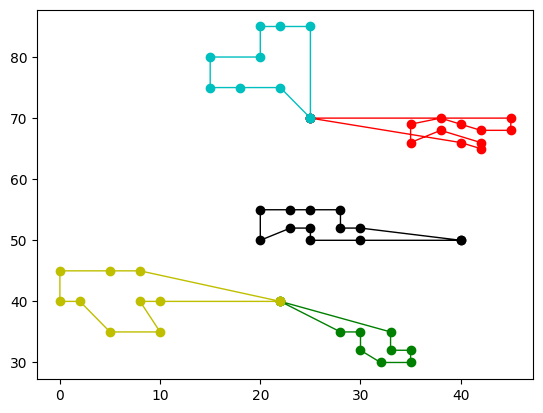

In [11]:
filename = "data_large_3dep.txt"

with open(filename, "r") as file:
    file_content = file.read()



data = []
for line in file_content.split('\n'):
    data.append(line.split())

dat = np.array(data, dtype = 'int')

# route

x_coords = []
y_coords = []
for path in route:
    x_coords.append(dat[path, 1])
    y_coords.append(dat[path, 2])

# x_coords

# y_coords

plt.plot(x_coords[0], y_coords[0], 'ro-', lw = 1);
plt.plot(x_coords[0][0], y_coords[0][0], 'ko');


plt.plot(x_coords[1], y_coords[1], 'go-', lw = 1);
plt.plot(x_coords[2], y_coords[2], 'bo-', lw = 1);
plt.plot(x_coords[3], y_coords[3], 'co-', lw = 1);
plt.plot(x_coords[4], y_coords[4], 'ko-', lw = 1);
plt.plot(x_coords[5], y_coords[5], 'yo-', lw = 1);
# plt.plot(x_coords[1][0], y_coords[1][0], 'ko');
# plt.plot(x_coords[2][0], y_coords[2][0], 'ko');

In [17]:
N

{(0, 0): <gurobi.Var Vehicle_Per_Depot[0,0] (value 0.0)>,
 (0, 1): <gurobi.Var Vehicle_Per_Depot[0,1] (value 0.0)>,
 (0, 2): <gurobi.Var Vehicle_Per_Depot[0,2] (value 0.0)>,
 (0, 3): <gurobi.Var Vehicle_Per_Depot[0,3] (value 0.0)>,
 (0, 4): <gurobi.Var Vehicle_Per_Depot[0,4] (value 0.0)>,
 (0, 5): <gurobi.Var Vehicle_Per_Depot[0,5] (value 0.0)>,
 (1, 0): <gurobi.Var Vehicle_Per_Depot[1,0] (value 0.0)>,
 (1, 1): <gurobi.Var Vehicle_Per_Depot[1,1] (value 0.0)>,
 (1, 2): <gurobi.Var Vehicle_Per_Depot[1,2] (value 0.0)>,
 (1, 3): <gurobi.Var Vehicle_Per_Depot[1,3] (value 0.0)>,
 (1, 4): <gurobi.Var Vehicle_Per_Depot[1,4] (value 0.0)>,
 (1, 5): <gurobi.Var Vehicle_Per_Depot[1,5] (value 0.0)>,
 (2, 0): <gurobi.Var Vehicle_Per_Depot[2,0] (value 1.0)>,
 (2, 1): <gurobi.Var Vehicle_Per_Depot[2,1] (value 1.0)>,
 (2, 2): <gurobi.Var Vehicle_Per_Depot[2,2] (value 1.0)>,
 (2, 3): <gurobi.Var Vehicle_Per_Depot[2,3] (value 1.0)>,
 (2, 4): <gurobi.Var Vehicle_Per_Depot[2,4] (value 1.0)>,
 (2, 5): <guro

In [7]:
pd.DataFrame(np.array(z.values()).reshape(len(a), -1)).applymap(conv)

C:\Users\Aditya Pavadad\AppData\Local\Temp\ipykernel_31460\4019488187.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pd.DataFrame(np.array(z.values()).reshape(len(a), -1)).applymap(conv)


,0,1,2,3,4,5
0,0,0,0,0,1,0
1,0,1,0,0,1,1
2,1,0,0,1,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
5,1,0,0,0,0,0
6,1,0,0,0,0,0
7,1,0,0,0,0,0
8,1,0,0,0,0,0
9,1,0,0,0,0,0


In [19]:
N

{(0, 0): <gurobi.Var Vehicle_Per_Depot[0,0] (value 0.0)>,
 (0, 1): <gurobi.Var Vehicle_Per_Depot[0,1] (value 0.0)>,
 (0, 2): <gurobi.Var Vehicle_Per_Depot[0,2] (value 0.0)>,
 (0, 3): <gurobi.Var Vehicle_Per_Depot[0,3] (value 0.0)>,
 (0, 4): <gurobi.Var Vehicle_Per_Depot[0,4] (value 0.0)>,
 (0, 5): <gurobi.Var Vehicle_Per_Depot[0,5] (value 0.0)>,
 (1, 0): <gurobi.Var Vehicle_Per_Depot[1,0] (value 0.0)>,
 (1, 1): <gurobi.Var Vehicle_Per_Depot[1,1] (value 0.0)>,
 (1, 2): <gurobi.Var Vehicle_Per_Depot[1,2] (value 0.0)>,
 (1, 3): <gurobi.Var Vehicle_Per_Depot[1,3] (value 0.0)>,
 (1, 4): <gurobi.Var Vehicle_Per_Depot[1,4] (value 0.0)>,
 (1, 5): <gurobi.Var Vehicle_Per_Depot[1,5] (value 0.0)>,
 (2, 0): <gurobi.Var Vehicle_Per_Depot[2,0] (value 1.0)>,
 (2, 1): <gurobi.Var Vehicle_Per_Depot[2,1] (value 1.0)>,
 (2, 2): <gurobi.Var Vehicle_Per_Depot[2,2] (value 1.0)>,
 (2, 3): <gurobi.Var Vehicle_Per_Depot[2,3] (value 1.0)>,
 (2, 4): <gurobi.Var Vehicle_Per_Depot[2,4] (value 1.0)>,
 (2, 5): <guro

In [7]:
z

{(0, 0): <gurobi.Var If_Node_Satisfied[0,0] (value 0.0)>,
 (0, 1): <gurobi.Var If_Node_Satisfied[0,1] (value 0.0)>,
 (0, 2): <gurobi.Var If_Node_Satisfied[0,2] (value 0.0)>,
 (0, 3): <gurobi.Var If_Node_Satisfied[0,3] (value 0.0)>,
 (0, 4): <gurobi.Var If_Node_Satisfied[0,4] (value 0.0)>,
 (0, 5): <gurobi.Var If_Node_Satisfied[0,5] (value 0.0)>,
 (1, 0): <gurobi.Var If_Node_Satisfied[1,0] (value 1.0)>,
 (1, 1): <gurobi.Var If_Node_Satisfied[1,1] (value 0.0)>,
 (1, 2): <gurobi.Var If_Node_Satisfied[1,2] (value 1.0)>,
 (1, 3): <gurobi.Var If_Node_Satisfied[1,3] (value 1.0)>,
 (1, 4): <gurobi.Var If_Node_Satisfied[1,4] (value 1.0)>,
 (1, 5): <gurobi.Var If_Node_Satisfied[1,5] (value 1.0)>,
 (2, 0): <gurobi.Var If_Node_Satisfied[2,0] (value 1.0)>,
 (2, 1): <gurobi.Var If_Node_Satisfied[2,1] (value 1.0)>,
 (2, 2): <gurobi.Var If_Node_Satisfied[2,2] (value 1.0)>,
 (2, 3): <gurobi.Var If_Node_Satisfied[2,3] (value 0.0)>,
 (2, 4): <gurobi.Var If_Node_Satisfied[2,4] (value 1.0)>,
 (2, 5): <guro